In [1]:
#import library yg dibutuhkan
from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")



In [2]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [3]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [4]:
category_dict = get_category_dict("C:/Users/USER/Downloads/mesinlearning/category.json")

In [5]:
trending = pd.read_csv("C:/Users/USER/Downloads/mesinlearning/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
    display(trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [6]:
from pandas import Timestamp

start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-02-07 05:46:51.832614+0000', tz='UTC')
end_date = Timestamp('2022-01-05 06:01:25.924242+0000', tz='UTC')


start_date = '2021-02-07 05:46:51.832614+00:00'
end_date = '2023-09-01 09:16:49.916211+00:00'


In [7]:
# Cek tipe data kolom trending_time terlebih dahulu:
print(trending['trending_time'].dtype)


object


In [8]:
# Coba konversi ulang dengan pd.to_datetime() dan pastikan kolomnya valid:
trending['trending_time'] = pd.to_datetime(trending['trending_time'], errors='coerce')


In [9]:
# Cek kembali tipe data setelah konversi:
print(trending['trending_time'].dtype)


datetime64[ns, UTC]


In [10]:
# Delete datadari februari - juni
filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.min()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date = Timestamp('2021-12-31 06:01:10.612541+0000', tz='UTC')

start_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')


In [11]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos = }")

num_videos = 81517


In [12]:
import pandas as pd

# Memeriksa info dari DataFrame filtered_trending
filtered_trending.info()


<class 'pandas.core.frame.DataFrame'>
Index: 81517 entries, 21322 to 172346
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           49717 non-null  object             
 1   publish_time       81517 non-null  datetime64[ns, UTC]
 2   channel_id         81517 non-null  object             
 3   title              81517 non-null  object             
 4   description        78544 non-null  object             
 5   thumbnail_url      49717 non-null  object             
 6   thumbnail_width    49717 non-null  float64            
 7   thumbnail_height   49717 non-null  float64            
 8   channel_name       81517 non-null  object             
 9   tags               70149 non-null  object             
 10  category_id        81517 non-null  int64              
 11  live_status        81517 non-null  object             
 12  local_title        81517 non-null  object     

In [13]:
# Deleet video dengan description koosng
filtered_trending.dropna(subset=["description"], inplace=True)

In [14]:
# Mengelompokkan data berdasarkan tanggal
trending_by_date = filtered_trending.groupby(filtered_trending.trending_time.dt.date)

# Menghitung jumlah video yang trending per hari
num_trending_per_day = trending_by_date['trending_time'].count()

# Menampilkan jumlah video yang trending per hari yang unik
print("Number of video in trending per day:", num_trending_per_day.unique())


Number of video in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200 381]


In [15]:
trending_duration = filtered_trending.groupby('title').agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)


,title,trending_duration,trending_start_date,trending_last_date
0,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
1,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
4,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,BORONG ISI KULKAS SAMA BABY SHARK!!!,32,2022-07-02 06:01:31.621266+00:00,2022-08-02 06:14:40.735514+00:00
9,gak bisa bahasa enggres,32,2022-07-01 06:01:38.284013+00:00,2022-08-01 06:01:08.899895+00:00


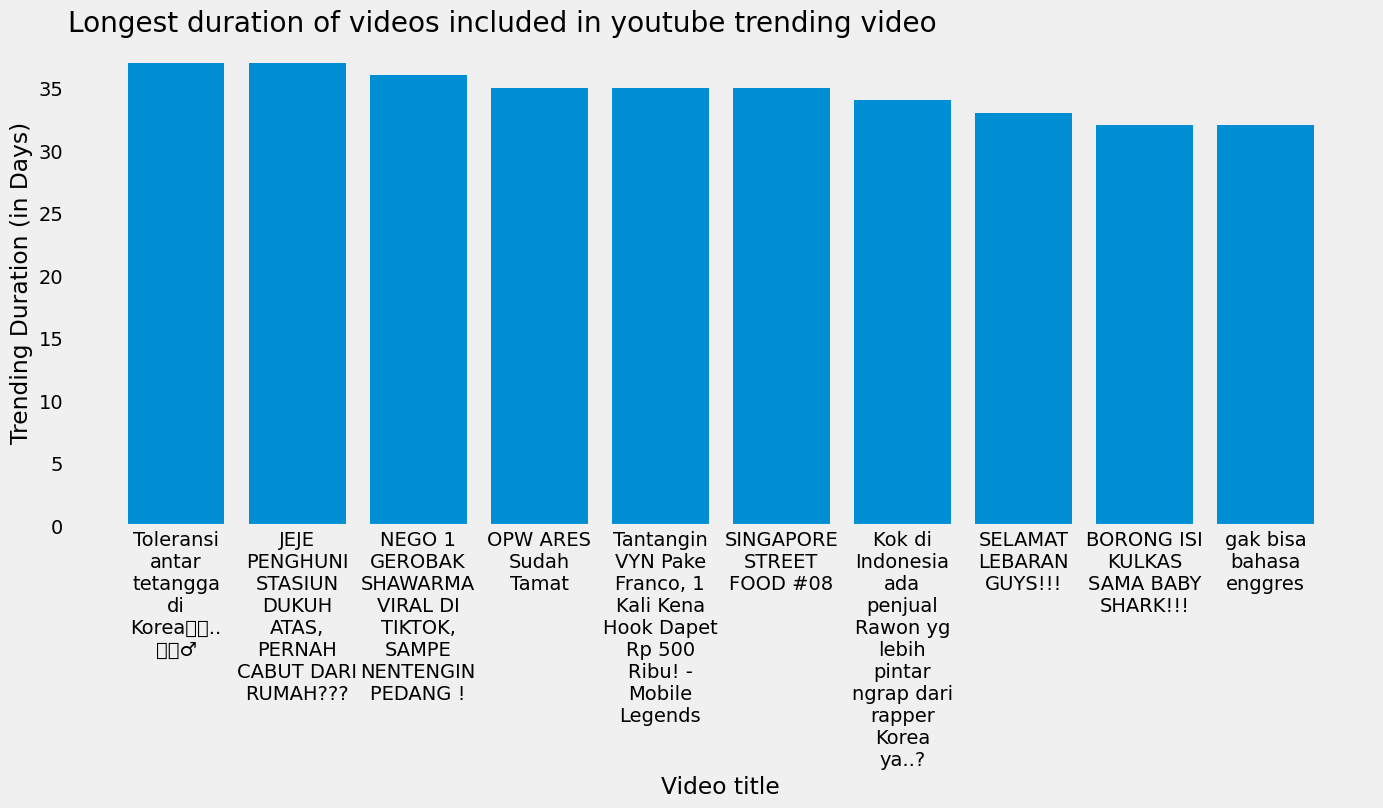

In [16]:
# Visualisasi data trending dengan chart bar
plt.figure(figsize=(15, 6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)
plt.title("Longest duration of videos included in youtube trending video", loc="left")
plt.xlabel("Video title")
plt.ylabel("Trending Duration (in Days)")
plt.grid(False)
plt.show()

In [17]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1798947.0  2064042.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1.981122e+06  19811225.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         41528.0   44699.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         43795.800000   437958.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

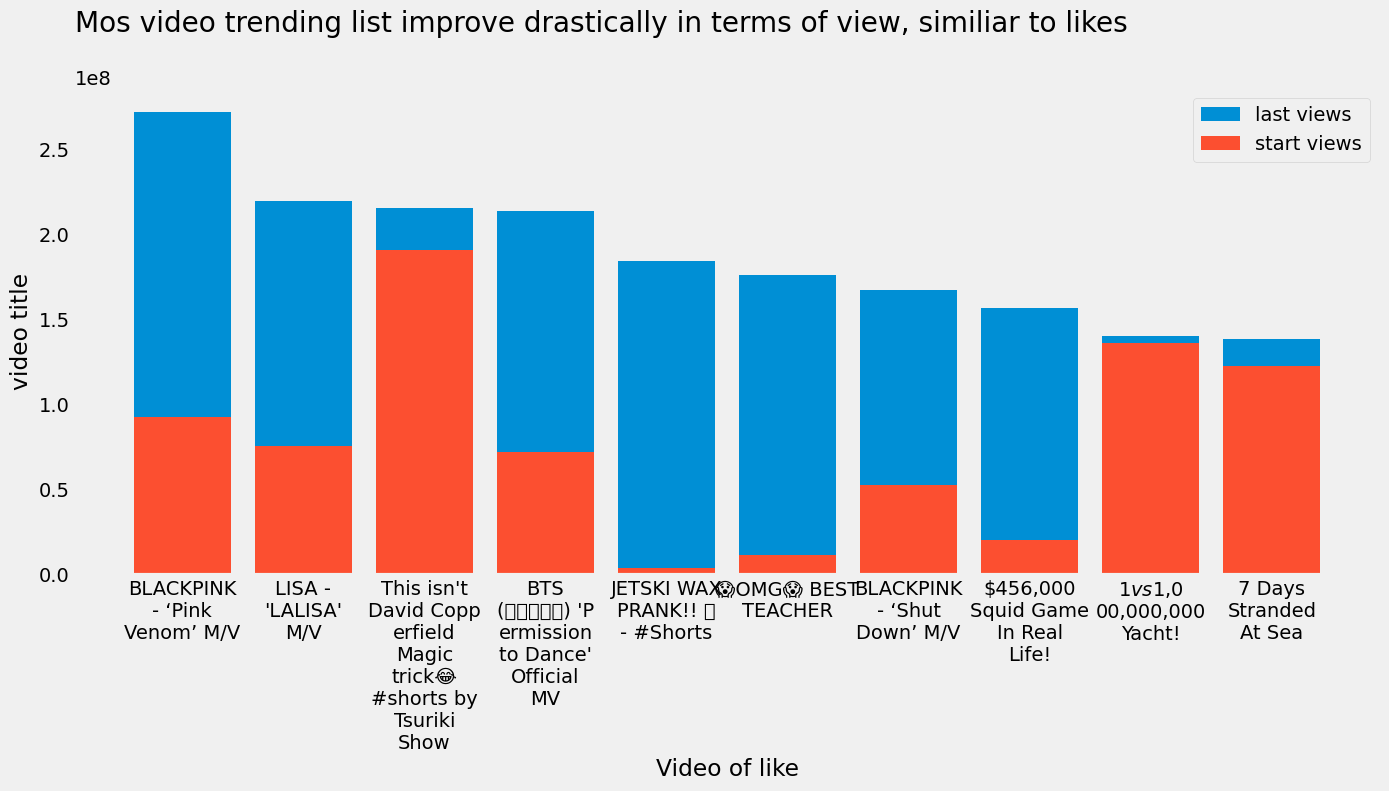

In [18]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="last views"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start views"
)
plt.title("Mos video trending list improve drastically in terms of view, similiar to likes", loc="left", y=1.1)
plt.xlabel("Video of like")
plt.ylabel("video title")
plt.legend()
plt.grid(False)
plt.show()

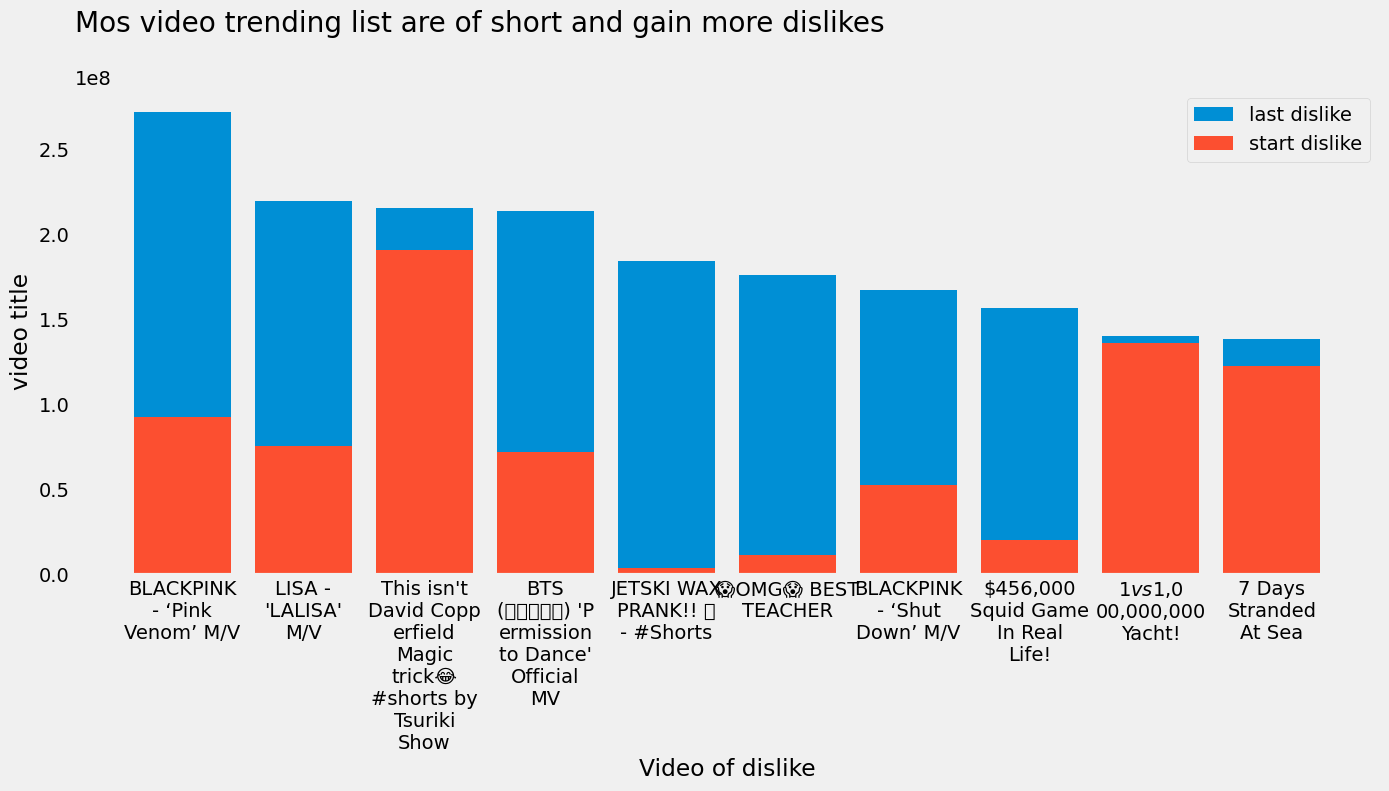

In [19]:
top_10_disliked = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last dislike"
)
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="start dislike"
)
plt.title("Mos video trending list are of short and gain more dislikes", loc="left", y=1.1)
plt.xlabel("Video of dislike")
plt.ylabel("video title")
plt.legend()
plt.grid(False)
plt.show()

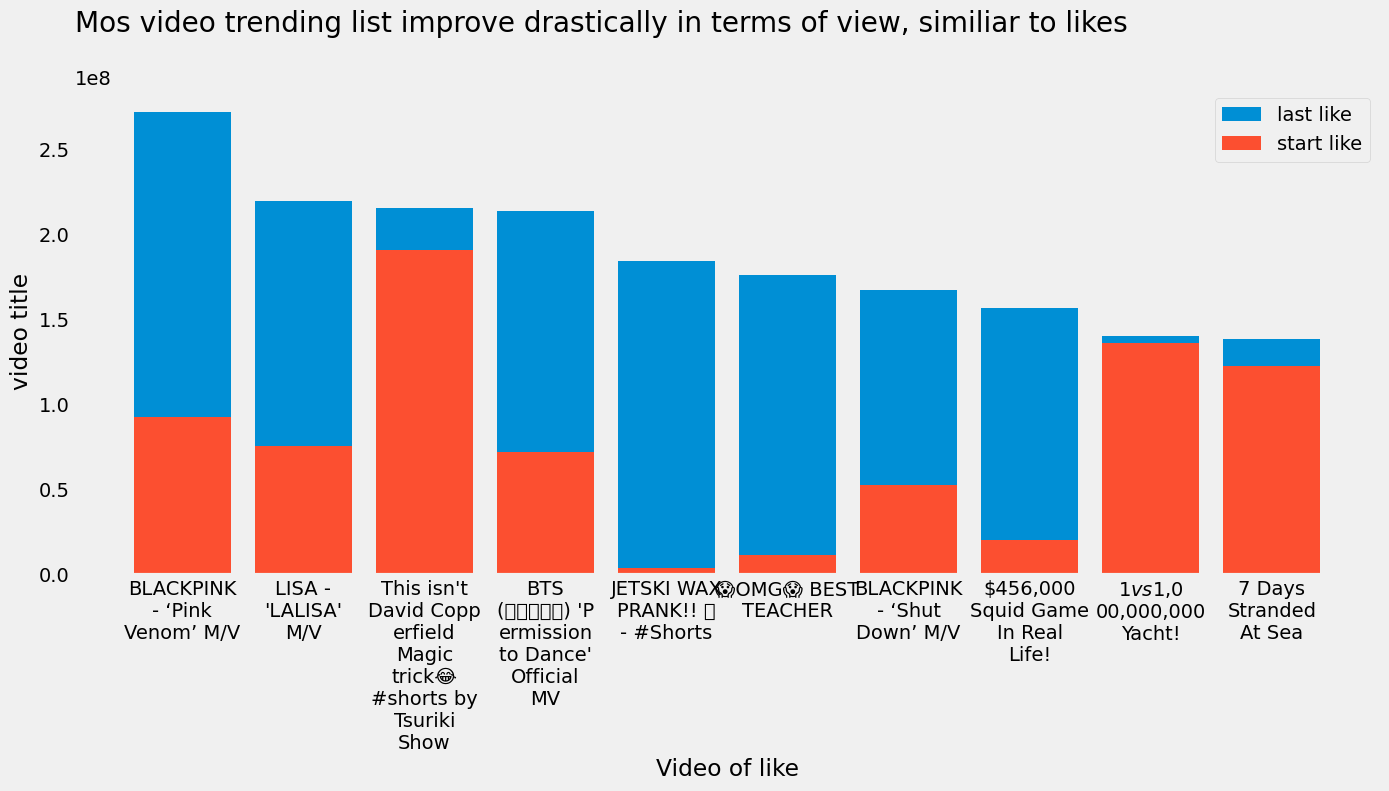

In [20]:
top_10_liked = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like"
)
plt.title("Mos video trending list improve drastically in terms of view, similiar to likes", loc="left", y=1.1)
plt.xlabel("Video of like")
plt.ylabel("video title")
plt.legend()
plt.grid(False)
plt.show()

In [21]:
# Data Preparation
# Contoh perhatikan berikut 
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineCha...,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSpon...
109477,The Pangeran and Justin Show: Badmin Son Hat-t...,Son Heung-min bikin langsung bikin hattrick se...
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 1...,PERSIB meraih kemenangan 3-0 atas Persik Kedir...
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG...,Galeri 19 | Part 7\n==========================...
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ri...,(COVER)Andekhi Anjaani - Putri Isnari feat Rid...
95923,Mira Putri ft Ageng Music - TIARA (Official Li...,Official Live Music : Mira Putri ft Ageng Musi...
121702,JKT48 New Era Special Performance Video – Eure...,Eureka Milik Kita hadir dengan konsep yang ber...
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR ...,#rachelvennya #covid #podcast
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,Silakan komen di bawah 🖤 Kalian mau aku buat k...
46159,Yeni Inka - Top Topan (Official Music Video AN...,Title: Top Topan\nArtist: Yeni Inka\nSongwrite...


In [22]:
# Merubah title dan descripsi video menjadi lowercase
sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [23]:
with pd.option_context("display.max_columns", 100):
    display(sample[["title", "title_lang", "description", "desc_lang"]])


,title,title_lang,description,desc_lang
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineCha...,tl,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSpon...,en
109477,The Pangeran and Justin Show: Badmin Son Hat-t...,en,Son Heung-min bikin langsung bikin hattrick se...,id
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 1...,id,PERSIB meraih kemenangan 3-0 atas Persik Kedir...,id
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG...,id,Galeri 19 | Part 7\n==========================...,id
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ri...,id,(COVER)Andekhi Anjaani - Putri Isnari feat Rid...,id
95923,Mira Putri ft Ageng Music - TIARA (Official Li...,id,Official Live Music : Mira Putri ft Ageng Musi...,id
121702,JKT48 New Era Special Performance Video – Eure...,da,Eureka Milik Kita hadir dengan konsep yang ber...,en
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR ...,id,#rachelvennya #covid #podcast,en
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,id,Silakan komen di bawah 🖤 Kalian mau aku buat k...,en
46159,Yeni Inka - Top Topan (Official Music Video AN...,id,Title: Top Topan\nArtist: Yeni Inka\nSongwrite...,id


In [24]:
# 1, coba detksi bahasa dari text berikut
def detect_language(text):
    """Detect language of the 'text'."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return

In [25]:
def detect_language(text):
    """Detect language of the 'text'."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return

In [26]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [ ]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

In [28]:
indo_trending = filtered-trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
    display(indo_trending.sample(10))

NameError: name 'filtered' is not defined

In [ ]:
# Feature Extraction 
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

In [ ]:
data.drop_duplicates(subset="title", inplace=True

In [ ]:
data.reset-index(drop=True, inplace=True)
date.shape

In [ ]:
# Feature Engineering 
    list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

    count = 0
    for em in list_emoji:
        for title in data.title:
            if em in title:
                count += 1
    print ("How many titles use emoji?", count)

In [ ]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [ ]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [ ]:
data["title_emoji" = data.title.apply(demojize)

In [ ]:
title-with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list-emoji
    if em in data.loc[idx, "title"]
]

In [ ]:
with pd.option_context("display.max_colwidth", 100):
    display(data.loc[title_with_emoji_idx])

In [32]:
# delete kolom title
    data.drop(columns="title", inplace=True)

IndentationError: unexpected indent (1065712353.py, line 2)

In [ ]:
# Ekplorasi
